In [1]:
import json
import math
import itertools
from collections import defaultdict, Counter
import numpy as np
from scipy.stats import spearmanr, shapiro, mannwhitneyu
from sklearn.cluster import SpectralClustering
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
%matplotlib inline

In [2]:
def build_graph(start_year, end_year):  
    if(end_year == -1):
        # Load data
        artists_dict = json.load(open(f"data/artists_{start_year}.json", "r"))
        related_dict = json.load(open(f"data/related_{start_year}.json", "r"))

        # Build graph
        G = nx.Graph()
        for artist, related in related_dict.items():
            for next_artist in related:
                G.add_edge(artist, next_artist)
    else:
        # Load data
        artists_dict = {}
        artist_id_set = set()
        related_dict = {}
        for year in range(start_year, end_year+1):
            #dictionary {key: {artist information}}
            year_artist_dict = json.load(open(f"data/artists_{year}.json", "r")) 
            for year_artist in year_artist_dict.keys():
                #check if artist id is currently in the set...
                year_artist_id = year_artist_dict[year_artist]["artist_id"]
                if year_artist_id not in artist_id_set:
                    artist_id_set.add(year_artist_id)
                    #right now I keep the earliest information of a repeating artist -- should I be updating it to be the latest -- that would be complicated...
                    artists_dict[year_artist]=year_artist_dict[year_artist] 

            #dictionary {artist id: {list of related artist ids}}
            year_related_dict = json.load(open(f"data/related_{year}.json", "r")) 
            for year_related_id in year_related_dict.keys():
                if year_related_id not in related_dict:
                    # add new key value pair to related_dict
                    related_dict[year_related_id]=year_related_dict[year_related_id]
                else:
                    # update the values for the key in related_dict
                    related_dict[year_related_id]=list(set(related_dict[year_related_id]+year_related_dict[year_related_id]))
        # Build graph
        G = nx.Graph()
        for artist, related in related_dict.items():
            for next_artist in related:
                G.add_edge(artist, next_artist)

    return G, artists_dict

In [3]:
# Partition graph
def partition_graph(n, graph):
    comp = nx.community.girvan_newman(graph)
    limited = itertools.takewhile(lambda c: len(c) <= n, comp)
    return list(limited)[-1]

In [4]:
#Get most common genre in partition
def get_name(node_list, artists_dict, idf):
    counts = defaultdict(int)
    for node in node_list:
        genres = artists_dict[node]["genres"]
        for genre in genres:
            counts[genre.replace(" ", "_")] += 1
    tf_idf = {k: v * idf[k] for k, v in counts.items()}
    return max(tf_idf, key=tf_idf.get)

In [5]:
# Generate colors and labels for graph
def graph_fav_artist(G, communities, cluster_labels):
    colors = []
    for node in G.nodes():
        for i in range(len(communities)):
            if node in communities[i]:
                colors.append(i)
    
    # Draw graph
    fig, ax = plt.subplots(figsize=(15,15))
    cm = plt.colormaps["tab20"]
    color_map = cm(range(len(communities)+1))
    pos=nx.spring_layout(G)
    for i, cluster in enumerate(communities):
        nx.draw_networkx_nodes(G, pos=pos, node_size=10, nodelist=cluster, ax=ax, node_color=[color_map[i+1]], 
                            linewidths=0.1, edgecolors='k', label=cluster_labels[i])
    nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color="#929591", width=0.5)
    ax.axis("off")
    fig.set_facecolor('k')
    lgnd = ax.legend(scatterpoints=1)
    for handle in lgnd.legend_handles:
        handle.set_sizes([20.0])
    plt.show()

Graph for year 2013
Number of nodes:  101
Number of edges:  150
Connected components:  2
Average clustering coefficient:  0.26118540425471126
Capital Cities indietronica
will.i.am dance pop
X Ambassadors folk-pop
Musiq Soulchild contemporary r&b
Avicii edm
Hoodie Allen indie pop rap
Panic! At The Disco pop punk
Linkin Park alternative metal
Ed Sheeran post-teen pop
Hucci electronic trap


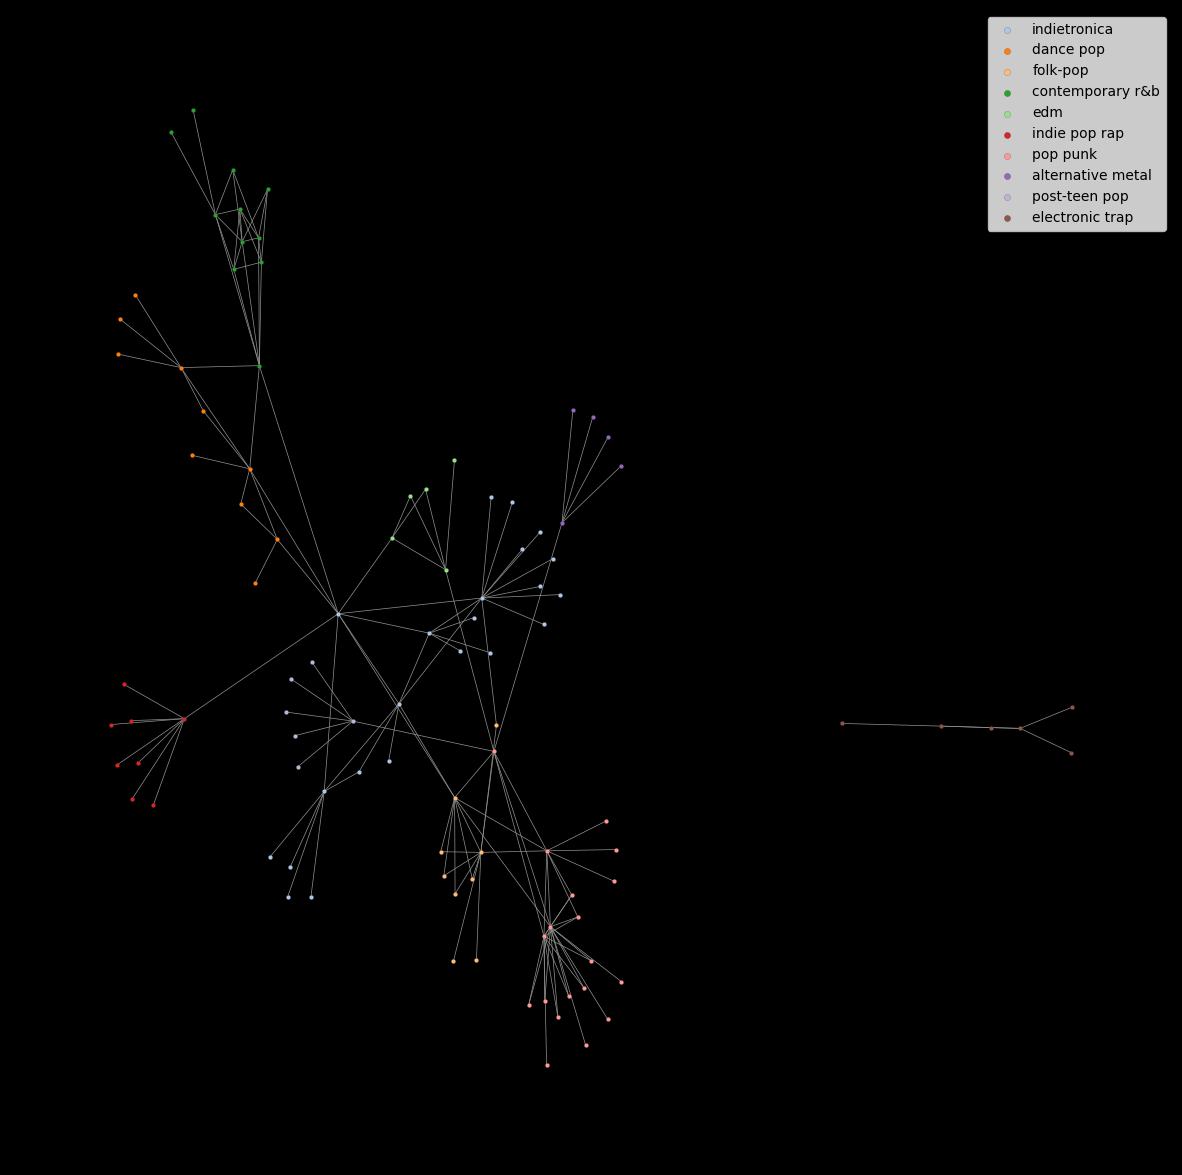

-----------------------------
Graph for year 2023
Number of nodes:  102
Number of edges:  222
Connected components:  4
Average clustering coefficient:  0.37537701469362367
Dustin Lynch country
HARDY modern country pop
Zach Bryan outlaw country
Parker McCollum classic texas country
Bebe Rexha pop
Jonas Brothers boy band
Taylor Swift pop
SZA rap
Metro Boomin trap
Carly Pearce country


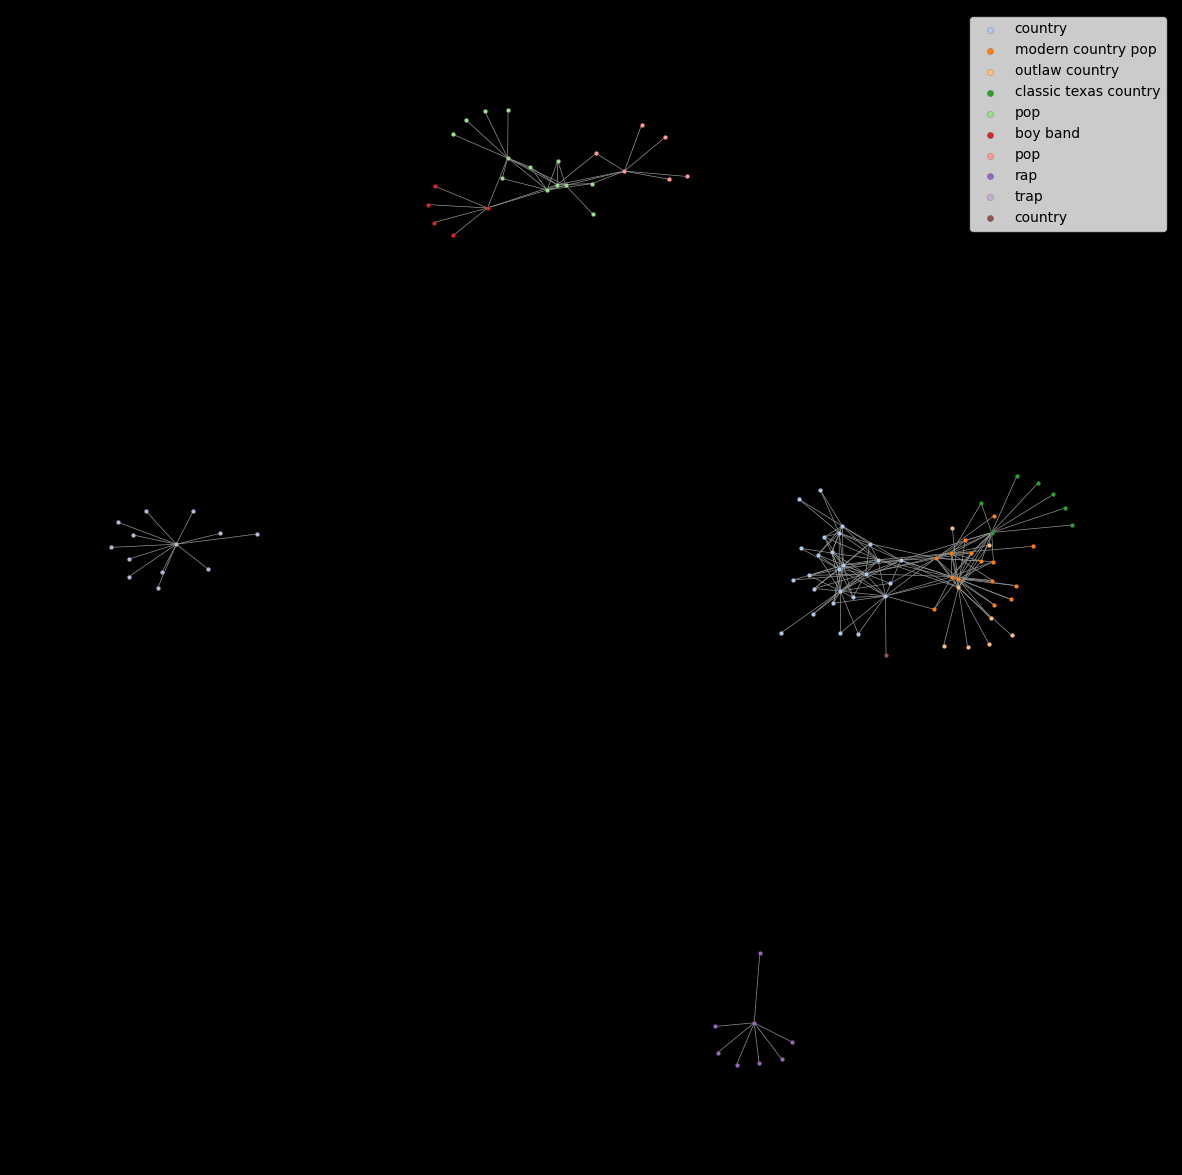

-----------------------------


In [7]:
#graphing individual year trends

years = [2013, 2023]

for year in years:
    G, artists_dict = build_graph(year, -1)
    print(f"Graph for year {year}")

    # Print basic graph properties
    print("Number of nodes: ", G.number_of_nodes())
    print("Number of edges: ", G.number_of_edges())
    print("Connected components: ", nx.number_connected_components(G))
    print("Average clustering coefficient: ", nx.average_clustering(G))

    # Clusters
    num_clusters = 10 #originally 30
    communities = partition_graph(num_clusters, G) 

    # # Compute inverse document frequencies
    idf = defaultdict(int)
    for partition in communities:
        genres = ["#".join(artists_dict[node]["genres"]) for node in partition]
        doc = "#".join(genres).replace(" ", "_").replace("#", " ")
        unique = set()
        for term in doc.split():
            if term not in unique:
                idf[term] += 1
                unique.add(term)
    idf = {k:math.log(len(communities)/v) for k, v in idf.items()}

    # Get center of each partition
    labels = {}
    cluster_labels = []
    for community in communities:
        sub = G.subgraph(list(community))
        sub_close = nx.closeness_centrality(sub)
        center = max(sub_close, key=sub_close.get)
        name = get_name(list(community), artists_dict, idf).replace("_", " ")
        labels[center] = name
        cluster_labels.append(name)
        print(artists_dict[center]["name"], name)

    #draw graph
    graph_fav_artist(G, communities, cluster_labels)
    print("-----------------------------")



Graph for years 2013-2023
Number of nodes:  202
Number of edges:  372
Connected components:  5
Average clustering coefficient:  0.3197819757735308
Capital Cities uk dance
Robin Thicke urban contemporary
Panic! At The Disco modern rock
Avicii edm
Hoodie Allen indie pop rap
Demi Lovato pop
Hucci electronic trap
Morgan Wallen contemporary country
SZA rap
Metro Boomin melodic rap


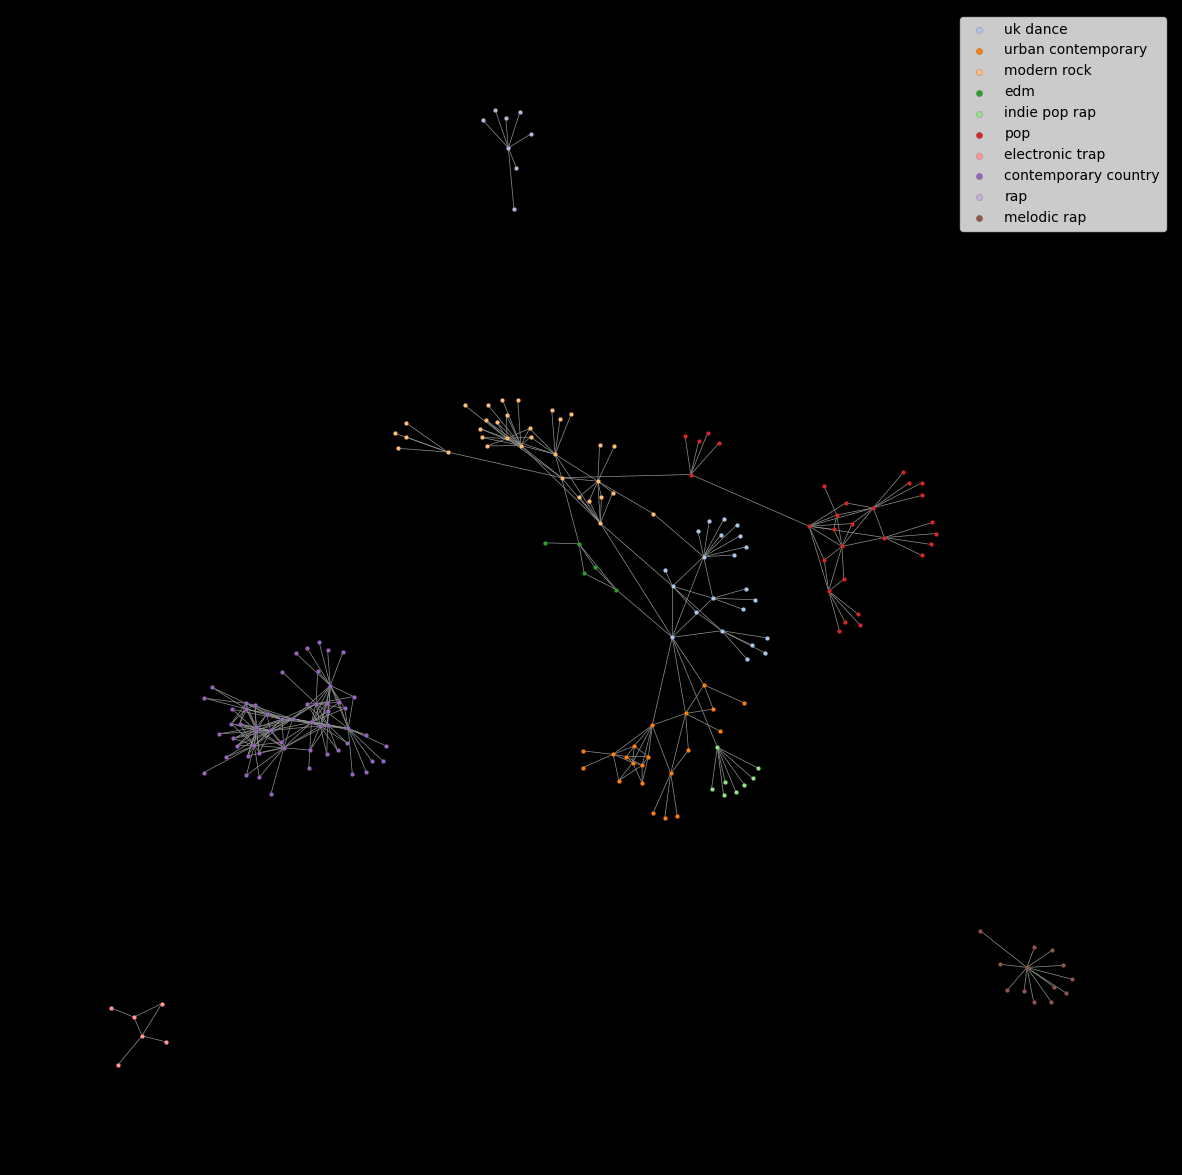

-----------------------------


In [6]:

# graphing cumulative years
# ex: 2013-2015, 2013-2023
# year_ranges = [(2013,2015),(2013,2023)]
year_ranges = [(2013,2023)]

for start_year,end_year in year_ranges:
    G, artists_dict = build_graph(start_year,end_year)
    print(f"Graph for years {start_year}-{end_year}")

    # Print basic graph properties
    print("Number of nodes: ", G.number_of_nodes())
    print("Number of edges: ", G.number_of_edges())
    print("Connected components: ", nx.number_connected_components(G))
    print("Average clustering coefficient: ", nx.average_clustering(G))

    # Clusters
    num_clusters = 10 #originally 30
    communities = partition_graph(num_clusters, G) 

    # # Compute inverse document frequencies
    idf = defaultdict(int)
    for partition in communities:
        genres = ["#".join(artists_dict[node]["genres"]) for node in partition]
        doc = "#".join(genres).replace(" ", "_").replace("#", " ")
        unique = set()
        for term in doc.split():
            if term not in unique:
                idf[term] += 1
                unique.add(term)
    idf = {k:math.log(len(communities)/v) for k, v in idf.items()}

    # Get center of each partition
    labels = {}
    cluster_labels = []
    for community in communities:
        sub = G.subgraph(list(community))
        sub_close = nx.closeness_centrality(sub)
        center = max(sub_close, key=sub_close.get)
        name = get_name(list(community), artists_dict, idf).replace("_", " ")
        labels[center] = name
        cluster_labels.append(name)
        print(artists_dict[center]["name"], name)

    #draw graph
    graph_fav_artist(G, communities, cluster_labels)
    print("-----------------------------")